# Gamma Exposure

Data: https://www.cboe.com/delayed_quotes

In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import re
import json
import requests

# Global configs
pd.options.display.float_format = '{:,.4f}'.format
plt.rcParams['figure.figsize'] = [15, 10] # Making the plot bigger.

# Target symbol. Update the symbol as needed
target_symbol = "SPY"
source_file = "data/{}.json".format(target_symbol)

## Fetch new version of the quote data

Dont spam this block as your IP may get blocked.

In [2]:
# Fake the user agent
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
response = requests.get("https://cdn.cboe.com/api/global/delayed_quotes/options/{}.json".format(target_symbol), headers=headers)

if response.status_code != 200:
    print("Fetch failed. Got code {} with message: {}".format(response.status_code, response.text))
else:
    with open(source_file, "wb") as f:
        f.write(response.content)
    print("Fetch success. Saved into " + source_file)


Fetch success. Saved into data/SPY.json


## Use the JSON data from the API instead of the CSV file

In [3]:
# open the json file instead
with open(source_file, "r") as json_file:
    options_data = json.load(json_file)

# Get SPX Spot
spotPrice = options_data['data']['close']
fromStrike = 0.8 * spotPrice
toStrike = 1.2 * spotPrice

# The timestamp in the json source data is in Zulu time as opposed to ajusted to your local TZ and rounded to nearest minute in the CSV version.
todayDate = datetime.strptime(options_data['timestamp'] + " +0000", "%Y-%m-%d %H:%M:%S %z") # Zulu TZ is added as the JSON value is in Zulu time. Hate it when they do not use fkn ISO-8601.

print("Using the following values:\n spot price: {}\n fromStrike: {}\n toStrike: {}\n date: {}".format(spotPrice, fromStrike, toStrike, todayDate))

Using the following values:
 spot price: 380.83
 fromStrike: 304.664
 toStrike: 456.996
 date: 2022-07-12 22:57:33+00:00


## Mapping the CSV version fields to the JSON fields

The CSV file format is not identical to what the API outputs. In fact, the CSV version is computed from the JSON data. The calls and puts are laid next to each other as opposed to one after the other in the JSON option array. The following table shows a mapping of the CSV version fields to the JSON fields.

### Calls

| CSV field (Calls) | Value example (line 14) | JSON fields | Value example (index 18) | Notes |
| --- | --- | --- | --- | --- |
| Expiration Date | Mon Jul 11 2022 | computed from option | option\[1\] | Zero indexed |
| Calls | SPY220711C00330000 | option | "SPY220711C00330000" | splits into with "C "signaling a call type: (SPY, 220711, C00330000) |
| Last Sale | 59.32 | last\_trade\_price | 59.32 |     |
|     |     | last\_trade\_time | "2022-07-08T12:06:07" | extra |
| Net | 0.505 | change | 0.505 |     |
| Bid | 58.5 | bid | 58.5 |     |
|     |     | bid_size | 300 | extra |
| Ask | 59.55 | ask | 59.55 |     |
|     |     | ask_size | 300 | extra |
| Volume | 2   | volume | 2   |     |
| IV  | 1.121 | iv  | 1.121 |     |
| Delta | 0.9996 | delta | 0.9996 |     |
| Gamma | 0.0001 | gamma | 0.0001 |     |
| Open Interest | 4   | open_interest | 4   |     |
| Strike | 330 | computed from option | option\[2\] / 1000 |     |
|     |     | __*Extra fields*__ |     |     |
|     |     | theta | 0   |     |
|     |     | rho | 0.0109 |     |
|     |     | vega | 0.0005 |     |
|     |     | theo | 59.53 |     |
|     |     | open | 59.84 |     |
|     |     | high | 59.84 |     |
|     |     | low | 59.32 |     |
|     |     | tick | "down" |     |
|     |     | percent_change | 0.858627 |     |
|     |     | prev\_day\_close | 58.81499863 |     |

### Puts

| CSV field (Puts) | Value example (line 14) | JSON fields | Value example (index 19) | Notes |
| --- | --- | --- | --- | --- |
| Puts | SPY220711P00330000 | option | "SPY220711P00330000" | splits into with "P"signaling a put type: (SPY, 220711, P00330000) |
| Last Sale | 0.01 | last\_trade\_price | 0.01 |     |
|     |     | last\_trade\_time | "2022-07-06T14:51:44" | extra |
| Net | 0   | change | 0   |     |
| Bid | 0   | bid | 0   |     |
|     |     | bid_size | 0   | extra |
| Ask | 0.01 | ask | 0.01 |     |
|     |     | ask_size | 4234 | extra |
| Volume | 0   | volume | 0   |     |
| IV  | 0.5876 | iv  | 0.5876 |     |
| Delta | -0.0004 | delta | -0.0004 |     |
| Gamma | 0.0001 | gamma | 0.0001 |     |
| Open Interest | 3689 | open_interest | 3689 |     |
|     |     | __*Extra fields*__ |     |     |
|     |     | theta | -0.002 |     |
|     |     | rho | 0   |     |
|     |     | vega | 0.0006 |     |
|     |     | theo | 0.0057 |     |
|     |     | open | 0   |     |
|     |     | high | 0   |     |
|     |     | low | 0   |     |
|     |     | tick | "no_change" |     |
|     |     | percent_change | 0   |     |
|     |     | prev\_day\_close | 0.005 |     |

## Adapting the JSON format to the CSV one

The JSON format is adapted to match the format displayed on the source web page and the generated CSV format. Since the JSON format is a list with calls and puts one after another, they are split into 2 lists then merged into a single table (dataframe) on a unique id generated from the option field. Example: `SPY220711C00290000 -> SPY22071100290000`. Adapting the format allows the use of most of the original script without changing it.


In [4]:
call_pattern = re.compile("^(\w{3})(\d{6})C(\d{8})$")
put_pattern = re.compile("^(\w{3})(\d{6})P(\d{8})$")
option_pattern = re.compile("^(\w{3})(\d{6})[CP](\d{8})$")

calls_json_to_csv = {
    "option": "Calls",
    "last_trade_price": "CallLastSale",
    "change": "CallNet",
    "bid": "CallBid",
    "ask": "CallAsk",
    "volume": "CallVol",
    "iv": "CallIV",
    "delta": "CallDelta",
    "gamma": "CallGamma",
    "open_interest": "CallOpenInt"
}

puts_json_to_csv = {
    "option": "Puts",
    "last_trade_price": "PutLastSale",
    "change": "PutNet",
    "bid": "PutBid",
    "ask": "PutAsk",
    "volume": "PutVol",
    "iv": "PutIV",
    "delta": "PutDelta",
    "gamma": "PutGamma",
    "open_interest": "PutOpenInt"
}

def make_uid(option_string):
    matches = option_pattern.match(option_string)
    return matches.group(1) + matches.group(2) + matches.group(3)

# Splits the calls and the puts in 2 lists to be turned into dataframes.
calls = list(filter(lambda opt: call_pattern.match(opt["option"]), options_data['data']['options']))
puts = list(filter(lambda opt: put_pattern.match(opt["option"]), options_data['data']['options']))
print("Calls count: {}, Puts count: {}.".format(len(calls), len(puts)))

# Transform the calls from the json format to match the csv original format.
callsdf = pd.DataFrame(calls).filter(["option", "last_trade_price", "change", "bid", "ask", "volume", "iv", "delta", "gamma", "open_interest"])
callsdf["ExpirationDate"] = callsdf["option"].apply(lambda opt: call_pattern.match(opt).group(2))
callsdf["ExpirationDate"] = pd.to_datetime(callsdf['ExpirationDate'], format='%y%m%d') + timedelta(hours=16)
callsdf['StrikePrice'] = callsdf["option"].apply(lambda opt: float(call_pattern.match(opt).group(3)) / 1000)
callsdf['id'] = callsdf["option"].apply(lambda opt: make_uid(opt))  # Generate an id to merge the calls and the puts together on a unique id. 
callsdf.rename(columns=calls_json_to_csv, inplace=True)

# Transform the puts from the json format to match the csv original format.
putsdf = pd.DataFrame(puts).filter(["option", "last_trade_price", "change", "bid", "ask", "volume", "iv", "delta", "gamma", "open_interest"])
putsdf['id'] = putsdf["option"].apply(lambda opt: make_uid(opt)) # Generate an id to merge the calls and the puts together on a unique id.
putsdf.rename(columns=puts_json_to_csv, inplace=True)

# Merge into the expected dataframe format for the rest of the functions.
df = pd.merge(callsdf, putsdf, on="id")
print("Sample:")
print(df.head(4))

Calls count: 4604, Puts count: 4604.
Sample:
                Calls  CallLastSale  CallNet  CallBid  CallAsk  CallVol  \
0  SPY220713C00290000       93.8700   0.0000  90.3700  90.9400   3.0000   
1  SPY220713C00295000       88.9000   0.0300  85.3700  85.9400   1.0000   
2  SPY220713C00300000       80.8600  -3.0100  80.3700  80.9400   1.0000   
3  SPY220713C00305000       76.2600  -2.6100  75.3700  75.9400   1.0000   

   CallIV  CallDelta  CallGamma  CallOpenInt  ...                Puts  \
0  0.0200     0.9999     0.0000      23.0000  ...  SPY220713P00290000   
1  0.0200     0.9999     0.0000       1.0000  ...  SPY220713P00295000   
2  0.0200     0.9999     0.0000       1.0000  ...  SPY220713P00300000   
3  0.0200     0.9999     0.0000       0.0000  ...  SPY220713P00305000   

   PutLastSale PutNet PutBid  PutAsk  PutVol  PutIV  PutDelta  PutGamma  \
0       0.0100 0.0000 0.0000  0.0100  0.0000 1.5434   -0.0001    0.0000   
1       0.0100 0.0000 0.0000  0.0100  0.0000 1.5010   -0.0001  

## Sergei's script

Source: https://perfiliev.co.uk/market-commentary/how-to-calculate-gamma-exposure-and-zero-gamma-level/.

This the the original scripts portions that have not been modified or only slightly.

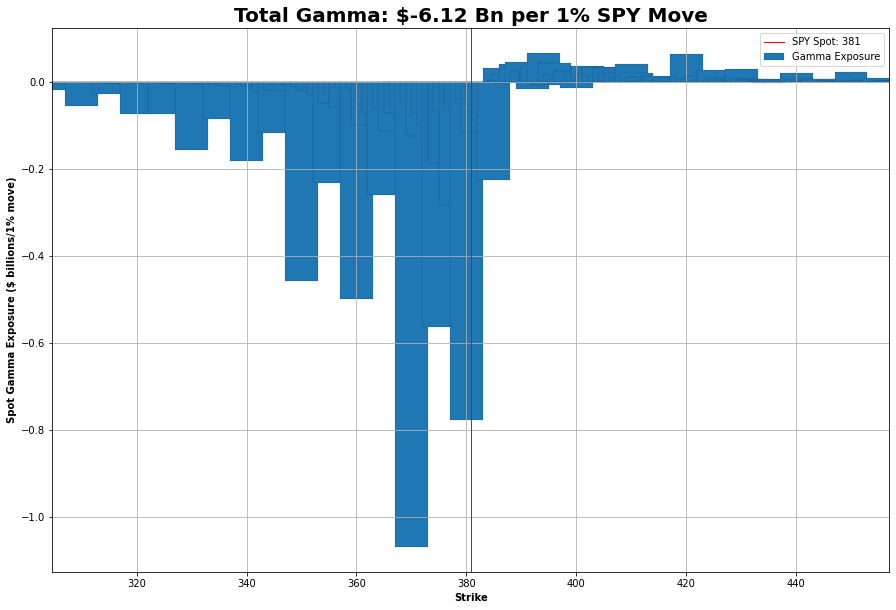

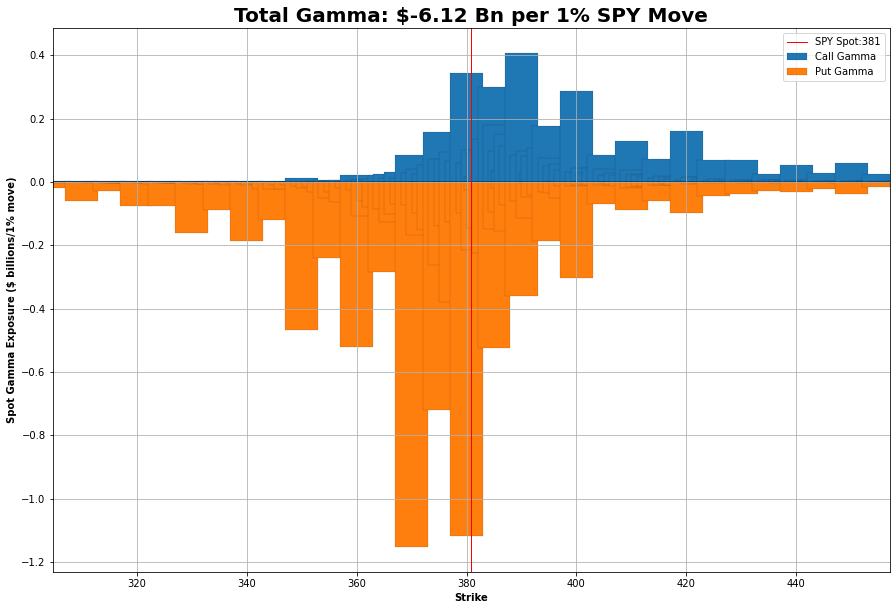

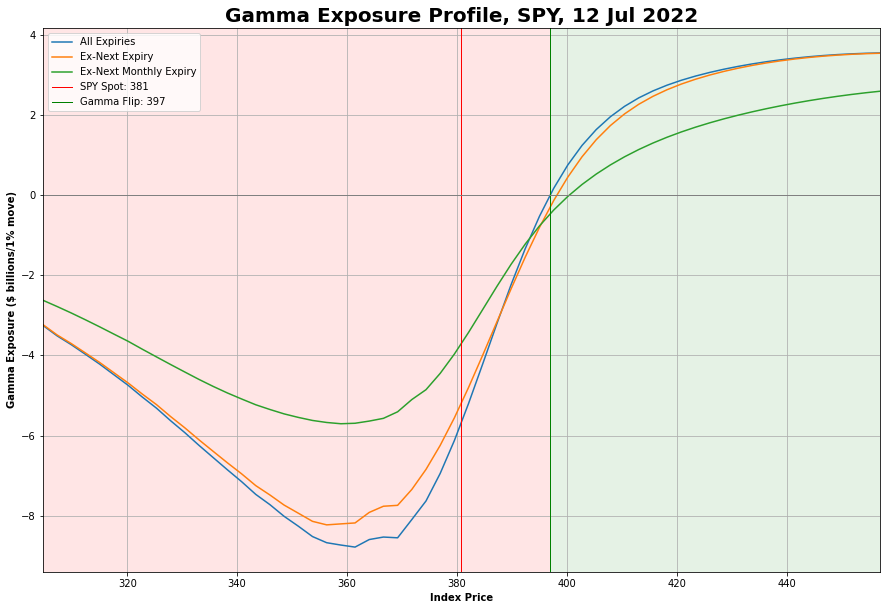

In [5]:
# Black-Scholes European-Options Gamma
def calcGammaEx(S, K, vol, T, r, q, optType, OI):
    if T == 0 or vol == 0:
        return 0

    dp = (np.log(S/K) + (r - q + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    dm = dp - vol*np.sqrt(T) 

    if optType == 'call':
        gamma = np.exp(-q*T) * norm.pdf(dp) / (S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 
    else: # Gamma is same for calls and puts. This is just to cross-check
        gamma = K * np.exp(-r*T) * norm.pdf(dm) / (S * S * vol * np.sqrt(T))
        return OI * 100 * S * S * 0.01 * gamma 

def isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21

# ---=== CALCULATE SPOT GAMMA ===---
# Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price 
# To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
df['CallGEX'] = df['CallGamma'] * df['CallOpenInt'] * 100 * spotPrice * spotPrice * 0.01
df['PutGEX'] = df['PutGamma'] * df['PutOpenInt'] * 100 * spotPrice * spotPrice * 0.01 * -1

df['TotalGamma'] = (df.CallGEX + df.PutGEX) / 10**9
dfAgg = df.groupby(['StrikePrice']).sum()
strikes = dfAgg.index.values

# Chart 1: Absolute Gamma Exposure
plt.grid()
plt.bar(strikes, dfAgg['TotalGamma'].to_numpy(), width=6, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% {} Move".format(target_symbol)
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="{} Spot: ".format(target_symbol) + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()

# Chart 2: Absolute Gamma Exposure by Calls and Puts
plt.grid()
plt.bar(strikes, dfAgg['CallGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Call Gamma")
plt.bar(strikes, dfAgg['PutGEX'].to_numpy() / 10**9, width=6, linewidth=0.1, edgecolor='k', label="Put Gamma")
plt.xlim([fromStrike, toStrike])
chartTitle = "Total Gamma: $" + str("{:.2f}".format(df['TotalGamma'].sum())) + " Bn per 1% {} Move".format(target_symbol)
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Strike', fontweight="bold")
plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="{} Spot:".format(target_symbol) + str("{:,.0f}".format(spotPrice)))
plt.legend()
plt.show()


# ---=== CALCULATE GAMMA PROFILE ===---
levels = np.linspace(fromStrike, toStrike, 60)

# For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
df['daysTillExp'] = [1/262 if (np.busday_count(todayDate.date(), x.date())) == 0 \
                           else np.busday_count(todayDate.date(), x.date())/262 for x in df.ExpirationDate]

nextExpiry = df['ExpirationDate'].min()

df['IsThirdFriday'] = [isThirdFriday(x) for x in df.ExpirationDate]
thirdFridays = df.loc[df['IsThirdFriday'] == True]
nextMonthlyExp = thirdFridays['ExpirationDate'].min()

totalGamma = []
totalGammaExNext = []
totalGammaExFri = []

# For each spot level, calc gamma exposure at that point
for level in levels:
    df['callGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['CallIV'], 
                                                          row['daysTillExp'], 0, 0, "call", row['CallOpenInt']), axis = 1)

    df['putGammaEx'] = df.apply(lambda row : calcGammaEx(level, row['StrikePrice'], row['PutIV'], 
                                                         row['daysTillExp'], 0, 0, "put", row['PutOpenInt']), axis = 1)    

    totalGamma.append(df['callGammaEx'].sum() - df['putGammaEx'].sum())

    exNxt = df.loc[df['ExpirationDate'] != nextExpiry]
    totalGammaExNext.append(exNxt['callGammaEx'].sum() - exNxt['putGammaEx'].sum())

    exFri = df.loc[df['ExpirationDate'] != nextMonthlyExp]
    totalGammaExFri.append(exFri['callGammaEx'].sum() - exFri['putGammaEx'].sum())

totalGamma = np.array(totalGamma) / 10**9
totalGammaExNext = np.array(totalGammaExNext) / 10**9
totalGammaExFri = np.array(totalGammaExFri) / 10**9

# Find Gamma Flip Point
zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

negGamma = totalGamma[zeroCrossIdx]
posGamma = totalGamma[zeroCrossIdx+1]
negStrike = levels[zeroCrossIdx]
posStrike = levels[zeroCrossIdx+1]

# Writing and sharing this code is only possible with your support! 
# If you find it useful, consider supporting us at perfiliev.com/support :)
zeroGamma = posStrike - ((posStrike - negStrike) * posGamma/(posGamma-negGamma))
zeroGamma = zeroGamma[0]

# Chart 3: Gamma Exposure Profile
fig, ax = plt.subplots()
plt.grid()
plt.plot(levels, totalGamma, label="All Expiries")
plt.plot(levels, totalGammaExNext, label="Ex-Next Expiry")
plt.plot(levels, totalGammaExFri, label="Ex-Next Monthly Expiry")
chartTitle = "Gamma Exposure Profile, {}, ".format(target_symbol) + todayDate.strftime('%d %b %Y')
plt.title(chartTitle, fontweight="bold", fontsize=20)
plt.xlabel('Index Price', fontweight="bold")
plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
plt.axvline(x=spotPrice, color='r', lw=1, label="{} Spot: ".format(target_symbol) + str("{:,.0f}".format(spotPrice)))
plt.axvline(x=zeroGamma, color='g', lw=1, label="Gamma Flip: " + str("{:,.0f}".format(zeroGamma)))
plt.axhline(y=0, color='grey', lw=1)
plt.xlim([fromStrike, toStrike])
trans = ax.get_xaxis_transform()
plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='green', alpha=0.1, transform=trans)
plt.legend()
plt.show()